In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tables
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
%matplotlib notebook

Note - the times in the text file are incorrect and the luminosities were calculated assuming that $\mu = 35.04 \; \mathrm{mag}$ when in fact we find, and adopt, $\mu = 34.89 \; \mathrm{mag}$ in the rest of the paper. 

The following to read in the data corrects these errors. 

In [2]:
raw_t, raw_lum, raw_lum_unc = np.loadtxt("16abc_lcbol_all.dat", unpack = True)
uvo_t, uvo_lum, uvo_lum_unc = np.loadtxt("16abc_ubvgri.dat", unpack = True)
o_t, o_lum, o_lum_unc = np.loadtxt("16abc_bgvri.dat", unpack = True)

In [7]:
t_MJD = raw_t * 1.023
lum = raw_lum * (10**(34.89/5 + 1)/10**(35.04/5 + 1) )**2
lum_unc = raw_lum_unc * (10**(34.89/5 + 1)/10**(35.04/5 + 1) )**2

uvo_t_mjd = uvo_t * 1.023
uvo_lum = uvo_lum * (10**(34.89/5 + 1)/10**(35.04/5 + 1) )**2
uvo_lum_unc = uvo_lum_unc * (10**(34.89/5 + 1)/10**(35.04/5 + 1) )**2

o_t_mjd = o_t * 1.023
o_lum = o_lum * (10**(34.89/5 + 1)/10**(35.04/5 + 1) )**2
o_lum_unc = o_lum_unc * (10**(34.89/5 + 1)/10**(35.04/5 + 1) )**2

In [3]:
# load light curve data
h5file = tables.open_file("iPTF16abc.h5", mode="r")
table = h5file.root.photometry

lc = {"P48/CFH12K": dict(), "P60/SEDm": dict(), "LCO-1m/Sinistro": dict(), "Swift/UVOT": dict()}
for filter_name in ["g", "R"]:
    lc["P48/CFH12K"][filter_name] =\
        np.array([(row["time"], row["flux"], row["flux_err"])
                  for row in table.where(
                      "(telescope == b'P48') & (filter_name == b'%s') & (mag_err < 10)" % filter_name)],
                 dtype=[("time", "f"), ("flux", "f"), ("flux_err", "f")])
for filter_name in ["g", "r", "i"]:
    lc["P60/SEDm"][filter_name] =\
        np.array([(row["time"], row["flux"], row["flux_err"])
                  for row in table.where(
                      "(telescope == b'P60') & (filter_name == b'%s')" % filter_name)],
                 dtype=[("time", "f"), ("flux", "f"), ("flux_err", "f")])
for filter_name in ["B", "V", "g", "r", "i"]:
    lc["LCO-1m/Sinistro"][filter_name] =\
        np.array([(row["time"], row["flux"], row["flux_err"])
                  for row in table.where(
                      "(telescope == b'LCO-1m') & (filter_name == b'%s')" % filter_name)],
                 dtype=[("time", "f"), ("flux", "f"), ("flux_err", "f")])
for filter_name in ["UVW2", "UVM2", "UVW1", "U", "B", "V"]:
    lc["Swift/UVOT"][filter_name] =\
        np.array([(row["time"], row["flux"], row["flux_err"])
                  for row in table.where(
                      "(telescope == b'Swift') & (filter_name == b'%s')" % filter_name)],
                 dtype=[("time", "f"), ("flux", "f"), ("flux_err", "f")])
        
spec_epochs = [t.attrs.OBS_DATE for t in h5file.root.spectroscopy]
    

ul = {}
ul["g"] = np.array([(row["time"], -2.5*np.log10(5*row["flux_err"]/3631))
                  for row in table.where(
                      "(telescope == b'P48') & (filter_name == b'g') & (time < 57481.2)")],
                 dtype=[("time", "f"), ("mag_lim", "f")])


lco_bv = {}

for filter_name in ["B", "V", "g", "r"]:
    lco_bv[filter_name] =\
        np.array([(row["time"], row["mag"], row["mag_err"])
                  for row in table.where(
                      "(telescope == b'LCO-1m') & (filter_name == b'%s')" % filter_name)],
                 dtype=[("time", "f"), ("mag", "f"), ("mag_err", "f")])




h5file.close()

In [4]:
T_MAX = 57499.537694
T_fl = 57481.2
z = 0.0234
mu = 34.89

A_B = 0.36
A_V = 0.27

colors = {"UVW2": "black",
          "UVM2": "Purple",
          "UVW1": "Cyan",
          "U": "DarkBlue",
          "B": "Blue",
          "V": "SkyBlue", 
          "g": "Green",
          "R": "Red", 
          "r": "Red",
          "i": "Yellow"}
markers = {"Swift": "h", 
           "P48": "o",
           "P60": "d",
           "LCO-1m": "s"}
offsets = {"UVW2": 6,
           "UVM2": 4,
           "UVW1": 4,
           "U": 3,
           "B": 2,
           "V": 1,
           "g": 0,
           "R": -1,
           "r": -1,
           "i": -3}

AAMcolors = {'Ni_models': "#2A3132",
             'g': "LightSeaGreen", 
             'UVW2-V': "#061283", # ultramarine
             'UVW1-V': "#00CFAA", # cyan
             'U-V': "#4897D8", # electric blue
             'B-V': "#012161", # royal blue
             'g-r': "#6599FF", # light blue #F77604", # caviar
             'r-i': "#FF0038"  # ripe tomato
            }


AAMoffsets = {'UVW2-V': 1, # midnight blue
              'UVW1-V': 1, # fig or #50312F eggplant
              'U-V': 2, # blueberry
              'B-V': 1, # yellow pepper
              'g-r': 0, # carrot
              'r-i': -1  # tomato
             }

<IPython.core.display.Javascript object>


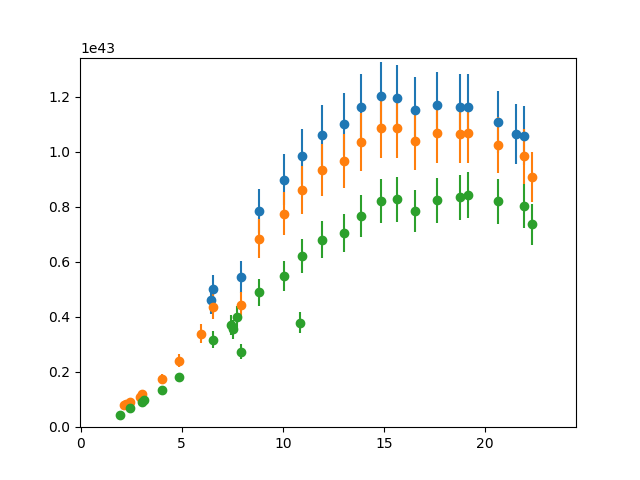

<Container object of 3 artists>

In [8]:
plt.errorbar((t_MJD - T_fl)/(1+z), lum, lum_unc, fmt = "o")
plt.errorbar((uvo_t_mjd - T_fl)/(1+z), uvo_lum, uvo_lum_unc, fmt = "o")
plt.errorbar((o_t_mjd - T_fl)/(1+z), o_lum, o_lum_unc, fmt = "o")

In [17]:
bol_max = np.argwhere(lum == max(lum))
print(t_MJD[bol_max], lum[bol_max], lum_unc[bol_max])

[[ 57496.384077]] [[  1.20260261e+43]] [[  1.23078359e+42]]


<IPython.core.display.Javascript object>


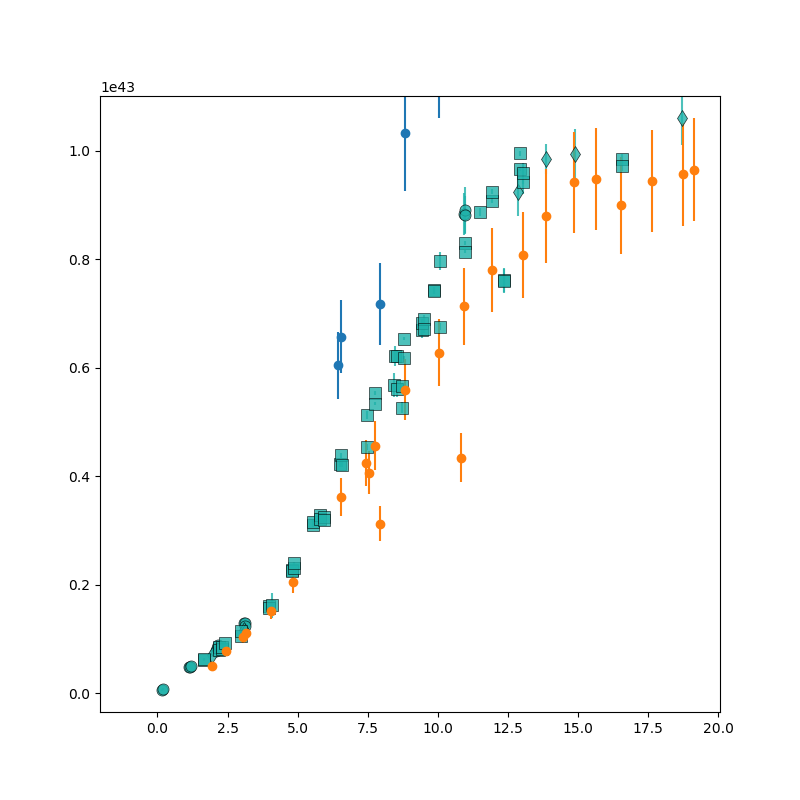

<Container object of 3 artists>

In [10]:
g_filt_dict = {"P48/CFH12K": "g", "P60/SEDm": "g'", "LCO-1m/Sinistro": "g'"}

fig, ax = plt.subplots(1, 1, sharex = False, figsize=(8,8))
for tel_inst in lc:
    if 'g' in lc[tel_inst].keys():
        tel = tel_inst.split("/")[0]
        inst = tel_inst.split("/")[1]
        curve = lc[tel_inst]['g']
        ax.errorbar((curve["time"] - T_fl)/(1+z) , 
                    curve["flux"] * 1e-23 * 6.359e14 * 4*np.pi*(10**(mu/5 + 1) * 3.086e+18)**2,
                    yerr=curve["flux_err"] * 1e-23 * 6.359e14 * 4*np.pi*(10**(mu/5 + 1) * 3.086e+18)**2, 
                    marker=markers[tel],
                    color=AAMcolors['g'],
                    linestyle='none',
                    mec = 'k',
                    mew = 0.5,
                    ms = 8,
                    alpha=0.8,
                    label="%s %s" % (tel_inst, g_filt_dict[tel_inst]))

ax.errorbar((t_MJD - T_fl)/(1+z), lum, lum_unc, fmt = "o")
ax.errorbar((o_t_mjd - T_fl)/(1+z), o_lum, o_lum_unc, fmt = "o")

## Compare colors to 2011fe

The data are being loaded from Zhang et al. 2016. They use different telescopes, and they find that: 

$E(B-V) = 0.008$, which corresponds to $A_B = 0.032$ and $A_V = 0.024$

and

$T_{B,\mathrm{max}} = 5814.98$ in the units of their table.

In [5]:
import pandas as pd
t_max_11fe = 5814.98
z_11fe = 0.00080
A_B_11fe = 0.032 # NED
A_V_11fe = 0.024 # NED
A_R_11fe = 0.019
ebv_11fe = A_B - A_V

# grab the data
lc_11fe = pd.read_csv("Zhang16.tab2")

In [6]:
def lc_color(t_blue, m_blue, m_blue_unc, t_red, m_red, m_red_unc, delta_t_merge = 1/24):
    """Return the (merged) color curve for two filters 
    
    Parameters
    ----------
    t_blue : array-like 
        Time array for blue filter measurements
        
    m_blue : array-like, shape = t_blue.shape
        mag array for the blue filter measurements
        
    m_blue_unc : array-like, shape = t_blue.shape
        mag uncertainties array for the blue filter measurements
    
    t_red : array-like
        Time array for red filter measurements
        
    m_red : array-like, shape = t_red.shape
        mag array for the red filter measurements
        
    m_red_unc : array-like, shape = t_red.shape
        mag uncertainties array for the red filter measurements

    delta_t_merge : float, optional (default = 1/24)
    
    Returns
    -------
    t_color : array-like
        mean time of joined red and blue filter obs 
    
    m_color : array-like
        mag of joined red and blue filter obs
    
    m_color_unc : array-like
        mag uncertainty for joined red and blue filter obs
    """

    if len(t_blue) != len(m_blue) or len(t_blue) != len(m_blue_unc):
        raise ValueError('Length of t_blue, m_blue, and m_blue_unc do not match')

    if len(t_red) != len(m_red) or len(t_red) != len(m_red_unc):
        raise ValueError('Length of t_red, m_red, and m_red_unc do not match')

    t_red = np.ma.array(t_red, mask = np.zeros(t_red.shape))
    m_red = np.ma.array(m_red, mask = np.zeros(m_red.shape))
    m_red_unc = np.ma.array(m_red_unc, mask = np.zeros(m_red_unc.shape))
    
    t_color = np.empty(0)
    m_color = np.empty(0)
    m_color_unc = np.empty(0)
    delta_t_merge = 1/24.
    
    for tb, mb, mbu in zip(t_blue, m_blue, m_blue_unc):
        if np.min(np.abs(t_red - tb)) < delta_t_merge:
            match_idx = np.argmin(np.abs(t_red - tb))
            t_color = np.append(t_color, (tb + t_red[match_idx]) / 2)
            m_color = np.append(m_color, mb - m_red[match_idx] )

            m_color_unc = np.append(m_color_unc, 
                                    np.hypot(mbu, m_red_unc[match_idx]))
            t_red.mask[match_idx] = True
    
    return t_color, m_color, m_color_unc

<IPython.core.display.Javascript object>


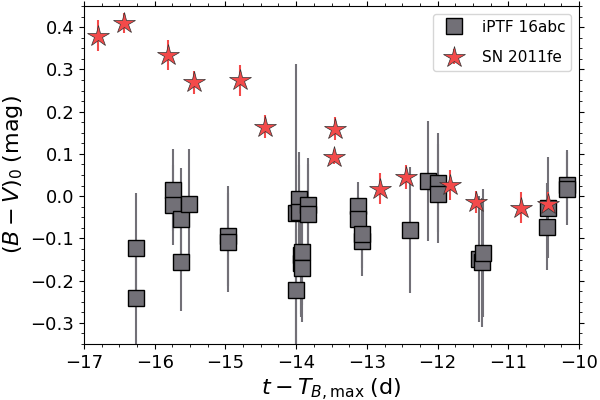

In [23]:
fig, ax = plt.subplots(figsize = (6,4))

t_16abc, bv_16abc, bv_unc_16abc = lc_color(lco_bv["B"]["time"],
                                           lco_bv["B"]["mag"],
                                           lco_bv["B"]["mag_err"],
                                           lco_bv["V"]["time"],
                                           lco_bv["V"]["mag"],
                                           lco_bv["V"]["mag_err"])

ax.errorbar( (t_16abc - T_MAX)/(1+z), bv_16abc - (A_B - A_V), bv_unc_16abc, # 0.11 correction from AB
             fmt = markers["LCO-1m"], 
             c = "#727077", 
             mew = 1, mec = "k", ms = 12,
             label = "iPTF 16abc")

bv_det = np.logical_and(lc_11fe["Bmag"] < 99, lc_11fe["Vmag"] < 99)
ax.errorbar( (lc_11fe["JD-2450000.5"][bv_det] - t_max_11fe)/(1+z_11fe), 
            lc_11fe["Bmag"][bv_det] - lc_11fe["Vmag"][bv_det] - (A_B_11fe - A_V_11fe), 
            np.hypot(lc_11fe["Bmag_unc"][bv_det], lc_11fe["Vmag_unc"][bv_det]),
            c = "#F34A4A",
            fmt = "*", mew = 0.5, mec = "0.2", ms = 16,
            label = "SN 2011fe")

# vr_det = np.logical_and(lc_11fe["Vmag"] < 99, lc_11fe["Rmag"] < 99)
# vr_11fe = lc_11fe["Vmag"][vr_det] - lc_11fe["Rmag"][vr_det] - (A_V_11fe - A_R_11fe)
# vr_unc_11fe = np.hypot(lc_11fe["Vmag_unc"][vr_det], lc_11fe["Rmag_unc"][vr_det])

ax.set_ylim(-0.35,0.45)
ax.set_xlim(-17,-10)
ax.set_xlabel(r"$t - T_{B,\mathrm{max}} \; (\mathrm{d})$", fontsize = 16)
ax.set_ylabel(r"$(B - V)_0 \; (\mathrm{mag})$", fontsize = 16)
ax.yaxis.set_minor_locator(MultipleLocator(0.025))
ax.xaxis.set_minor_locator(MultipleLocator(0.25))
ax.tick_params(axis='both', which='both', top=True, right=True, labelsize=13)


ax.legend(labelspacing = 1, fontsize=11)

fig.subplots_adjust(bottom=0.14,left=0.14,right=0.965,top=0.985)
# fig.savefig("16abc_11fe_colors.pdf")

In [47]:
lco_bv["B"]["mag"]

array([ 19.07139969,  19.00510025,  18.80879974,  18.80579948,
        18.79450035,  18.74419975,  18.73430061,  18.47550011,
        18.50790024,  17.90089989,  18.02160072,  18.04829979,
        18.06410027,  18.06220055,  18.04260063,  17.92379951,
        17.97060013,  18.03809929,  17.98839951,  18.02370071,
        18.00769997,  17.97060013,  17.93560028,  17.76339912,
        17.75079918,  17.61260033,  17.65570068,  17.3614006 ,
        17.29840088,  17.29400063,  17.34799957,  17.35129929,
        17.04109955,  16.96920013,  17.04540062,  16.85580063,
        16.88739967,  16.81430054,  16.80520058,  16.59900093,
        16.50880051,  16.65839958,  16.64159966,  16.5454998 ,
        16.51420021,  16.38829994,  16.43569946,  16.38879967,
        16.5394001 ,  16.44519997,  16.38619995,  16.51819992,
        16.46789932,  16.43689919,  16.42329979,  16.30430031,
        16.3234005 ,  16.22069931,  16.21859932,  16.1284008 ,
        16.1977005 ,  16.19009972,  16.19020081,  16.20